In [1]:
from keras import backend as K
from keras.layers import Dense,Input,Lambda,regularizers,BatchNormalization,initializers,Activation
from keras.optimizers import adam,rmsprop
from keras.models import Model,load_model
import numpy as np
import random
from collections import namedtuple, deque
import sys
import pandas as pd
from task import Task
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
                        #########################################
                        #<This code is copied from the internet>#
                        #########################################
class Buffer:
    def __init__(self, size, observation_shape, action_shape, observation_dtype=np.float, action_dtype=np.integer, reward_dtype=np.float):
        self.size = size
        self.observation_shape = observation_shape
        self.action_shape = action_shape

        self.preobs = np.empty((self.size,) + observation_shape, dtype=observation_dtype)
        self.actions = np.empty((self.size,) + action_shape, dtype=action_dtype)
        self.rewards = np.empty(self.size, dtype=reward_dtype)
        self.postobs = np.empty((self.size,) + observation_shape, dtype=observation_dtype)
        self.terminals = np.empty(self.size, dtype=np.bool)

        self.count = 0
        self.current = 0

    def add(self, preobs, action, reward, postobs, terminal):
        assert preobs.shape == self.observation_shape
        assert action.shape == self.action_shape
        assert postobs.shape == self.observation_shape
        self.preobs[self.current] = preobs
        self.actions[self.current] = action
        self.rewards[self.current] = reward
        self.postobs[self.current] = postobs
        self.terminals[self.current] = terminal
        self.count = max(self.count, self.current + 1)
        self.current = (self.current + 1) % self.size

    def addBatch(self, preobs, actions, rewards, postobs, terminals):
        for preob, action, reward, postob, terminal in zip(preobs, actions, rewards, postobs, terminals):
            self.add(preob, action, reward, postob, terminal)

    def sample(self, batch_size):
        assert self.count > 0
        indexes = np.random.choice(self.count, size=batch_size)
        return self.preobs[indexes], self.actions[indexes], self.rewards[indexes], self.postobs[indexes], self.terminals[indexes]
    
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = self.mu.copy()

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state
                ##########################
                ###<End of copied code>###
                ##########################

In [3]:
class Network:
    def __init__(self,input_shape,output_shape,num_layers=1,activation='linear',
                 num_nodes=50,tau=0.1,min_val=0,max_val=1):
        assert num_layers>0,'minimum 1 layer'
        self.tau = tau
        self.min = min_val
        self.max = max_val
        self.model,self.mod_inp = self._create_network(input_shape,output_shape,num_layers=num_layers,
                             activation=activation,num_nodes=num_nodes)
        self.target,self.targ_inp = self._create_network(input_shape,output_shape,num_layers=num_layers,
                             activation=activation,num_nodes=num_nodes)
        self.target.set_weights(self.model.get_weights())
        
    def _create_network(self,input_shape,output_shape,num_layers,activation,num_nodes):

    
    def Update_target(self):
        weights = self.model.get_weights()
        target_weights = self.target.get_weights()
        for i in range(len(weights)):
            target_weights[i] = self.tau * weights[i] + (1 - self.tau) * target_weights[i]
        self.target.set_weights(target_weights)

In [4]:
class DDPG:
    def __init__(self,task,insize=18,naction=4,bs=128,memory_size=20000,activation=['relu','relu'],gamma=0.99):
        self.task =task
        self.bs = bs
        self.gamma = gamma
        self.actor = Network((insize,),naction,num_layers=2,num_nodes=300,activation=['tanh','tanh','sigmoid'],max_val=900)
        self.critic = Network((insize+naction,),1,num_layers=2,num_nodes=300,activation=['tanh','tanh','linear'])
        #self.critic.model.compile(optimizer=adam(lr=0.001),loss='mse')
        self.critic.model.compile(optimizer=rmsprop(lr=0.001),loss='mse')

        def loss(y_true, y_pred):
            return -self.critic.model(K.concatenate([self.actor.mod_inp, y_pred], axis=1))
        #self.actor.model.compile(optimizer=adam(lr=0.0001), loss=loss)
        self.actor.model.compile(optimizer=rmsprop(lr=0.00003), loss=loss)
        #Create another model to train the actor weights.
        
        # Define loss function using action value (Q value) gradients
        #gradients = Input(shape=(naction,))
        #loss = K.mean(-gradients * self.actor.model.output)

        # Define optimizer and training function
        #optimizer = adam(lr=.0001)
        #updates_op = optimizer.get_updates(params=self.actor.model.trainable_weights, loss=loss)
        #self.training_actor = K.function(inputs=[self.actor.mod_inp, gradients, K.learning_phase()],
        #    outputs=[], updates=updates_op)
        
        #Gradient of output wrt the input of the model (Tensor)
                # Compute action gradients (derivative of Q values w.r.t. to actions)
        #critic_gradients = K.gradients(self.critic.model.output, self.critic.model.input)
        
        # Define an additional function to fetch action gradients (to be used by actor model)
        #self.get_action_gradients = K.function( inputs=[self.critic.model.input, K.learning_phase()], outputs=critic_gradients)     
        
        # mean is 0, theta:0.15, sigma:0.2 (DDPG paper)
        self.noise = OUNoise(4,0,0.15,0.2)
        #self.actor.model.compile(optimizer='adam',loss=self.New_loss)
        self.Replay = Buffer(memory_size,(insize,),(1,naction),action_dtype=np.float)
    
    
    def Reset(self):
        self.noise.reset()
        state = self.task.reset()
        self.actor.Update_target()
        self.critic.Update_target()
        return state
        
    def Get_action(self,state):
        #return np.clip(self.actor.model.predict(state) +self.noise.sample(),1e-6,1)
        return np.clip(self.actor.model.predict(state),1e-6,1)
        
    def train_models(self):
        if self.Replay.count>=2*self.bs:
            states,actions,rewards,next_states,dons = self.Replay.sample(self.bs)
            actions_prime = self.actor.target.predict(next_states)
            critic_input = np.concatenate([next_states,actions_prime],axis=1)
            critic_target = rewards + self.gamma*self.critic.target.predict(critic_input)[:,0]*(1-dons)
            # Training critic model.
            ch = self.critic.model.train_on_batch(np.concatenate([states,actions[:,0,:]],axis=1),critic_target)
            #self.calculate(np.concatenate([states,actions[:,0,:]],axis=1))
            #x = self.get_action_gradients([np.concatenate([states,actions[:,0,:]],axis=1),0])
            #grd = []
            #for i in range(len(x[0])):
            #    grd.append(x[0][i][-4:])
            
            ### Calculate the gradient
            #K.backend.gradients()
            # Trraining actor model
            #self.training_actor([states,grd,1])
            ah = self.actor.model.train_on_batch(states, actions)
            #Update target models.
            self.actor.Update_target()
            self.critic.Update_target()
            return ch,ah
        return None

In [5]:
num_episodes = 500
target_pos = np.array([0., 0., 500.])
task = Task(target_pos=target_pos)
agent = DDPG(task)
worst_score = np.inf
best_score = -np.inf
reward_log = "reward.txt"
reward_labels = ['episode', 'reward','critic_loss','actor_loss','steps_count']
reward_results = {x : [] for x in reward_labels}

In [6]:
for i_episode in range(1, num_episodes+1):
    state = agent.Reset() # start a new episode
    episode_reward=0
    steps_count =0
    while True:
        action = agent.Get_action(state[np.newaxis,:])
        next_state, reward, done = task.step(action[0]*900)
        steps_count+=1
        episode_reward+=reward
        agent.Replay.add(state, action, reward, next_state, done)
        state = next_state
        info = agent.train_models()
        if info:
            #ah = agent.actor.model.train_on_batch(state[np.newaxis,:], action[np.newaxis, :])
            
            reward_results['critic_loss'].append(info[0])
            reward_results['actor_loss'].append(info[1])
        if done:
            print("\rEpisode = {:4d}, reward = {:7.3f} , steps count = {}".format(
                i_episode, episode_reward,steps_count), end="")  # [debug]
            reward_results['episode'].append(i_episode)
            reward_results['reward'].append(episode_reward)
            reward_results['steps_count'].append(steps_count)
            break
    sys.stdout.flush()
    

Episode =  500, reward =  87.502 , steps count = 24

In [7]:
state = agent.Reset() # start a new episode
episode_reward=0
steps_count =0
while True:
    action = np.array([0.5,0.5,0.5,0.5])
    next_state, reward, done = task.step(action*900)
    steps_count+=1
    episode_reward+=reward
    if done:
        print("\rEpisode = {:4d}, reward = {:7.3f} , steps count = {}".format(
            i_episode, episode_reward,steps_count), end="")  # [debug]
        break

Episode =  500, reward = 298.458 , steps count = 84

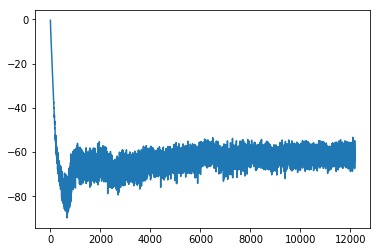

In [8]:
plt.plot(reward_results['actor_loss'])

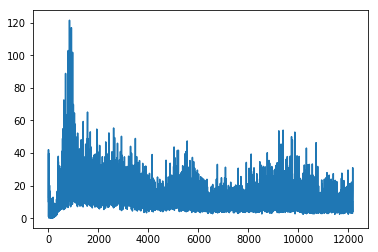

In [9]:
plt.plot(reward_results['critic_loss'])

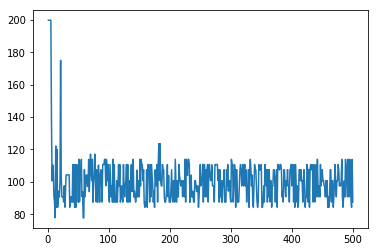

In [10]:
plt.plot(reward_results['episode'],reward_results['reward'])

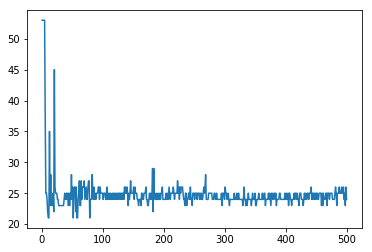

In [11]:
plt.plot(reward_results['episode'],reward_results['steps_count'])

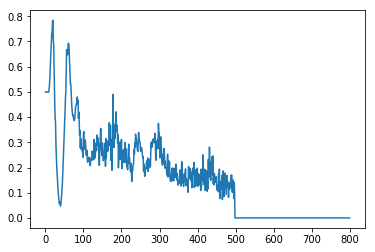

In [12]:
plt.plot(np.mean(agent.Replay.actions[:,0].reshape(-1,100),axis=1))